# Fraud Detection in Financial Transactions using Machine Learning Techniques

**Description:** This project aims to analyze an Online Payment Fraud Detection dataset using various machine learning techniques to identify the most effective approach for fraud detection. The dataset encompasses transactional attributes such as transaction type, amount, participant information (initiating customer and recipient), and fraud indicator.

**Objectives:**

- Explore the dataset to understand its structure and attributes. 
- Preprocess the data, including handling missing values, encoding categorical variables, and scaling numerical features.
- Implement machine learning algorithms such as Logistic Regression, Random Forest, XGBoost and LightGBM  for fraud detection.
- Evaluate the performance of each algorithm using relevant metrics such as accuracy, precision, recall, and F1-score.
- Compare the performance of different algorithms to determine the most effective approach for fraud detection in online payments.


**Attributes:**

**step:** This attribute represents time intervals, with each step equivalent to one hour. It helps track the temporal aspect of transactions, providing insights into when they occur within a timeframe.

**type:** Initial account balance of the recipient before the transaction.
 Denotes the transaction category, such as money transfers, payments, cash-out, debit, or cash-in.

**amount:** The amount attribute signifies the monetary value associated with each transaction. It quantifies the financial magnitude of the transaction, indicating the funds involved.

**nameOrig:** This field identifies the customer initiating the transaction. It associates each transaction with the account holder responsible for its initiation.

**oldbalanceOrg:** Reflecting the initial account balance of the customer before the transaction, oldbalanceOrg provides a starting point for the financial position of the account holder.

**newbalanceOrig:** After the transaction, newbalanceOrig indicates the updated account balance of the customer. It captures the changes in the account balance resulting from the transaction.

**nameDest:** This attribute identifies the recipient of the transaction. It associates transactions with the account to which funds are being transferred or directed.

**oldbalanceDest:** Reflecting the initial account balance of the recipient before the transaction, oldbalanceDest offers insights into the starting financial position of the recipient account.

**newbalanceDest:** Initial account balance of the recipient before the transaction.

**isFraud:** This binary indicator distinguishes fraudulent transactions (1) from non-fraudulent ones (0). It helps identify transactions involving fraudulent behavior within the dataset.





In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import iqr
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier



# Data Pre-Processing

Provides an initial understanding of the dataset's structure, identifies any inconsistencies or missing values, and lays the groundwork for further data analysis and preprocessing. 

In [2]:
df = pd.read_csv('fraud_dataset.csv')


In [3]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Display basic information about the dataset
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Display summary statistics
df.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Renaming oldbalanceOrg it is inconsistent wl dataset to prevent confusion.

In [6]:
# rename oldbalanceOrg inconsistent wl dataset
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})


In [7]:
print(df.columns)


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')


In [87]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


In [8]:
df.duplicated().sum()

0

# EDA

In [9]:
num_rows, num_columns = df.shape

print(f"Number of rows: {num_rows:,}")
print("Number of columns:", num_columns)

Number of rows: 6,362,620
Number of columns: 11


In [10]:
unique_types = df['type'].unique();
type_counts = df['type'].value_counts()

num_unique_types = len(unique_types)
print(type_counts)

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Distribution of Transaction Types

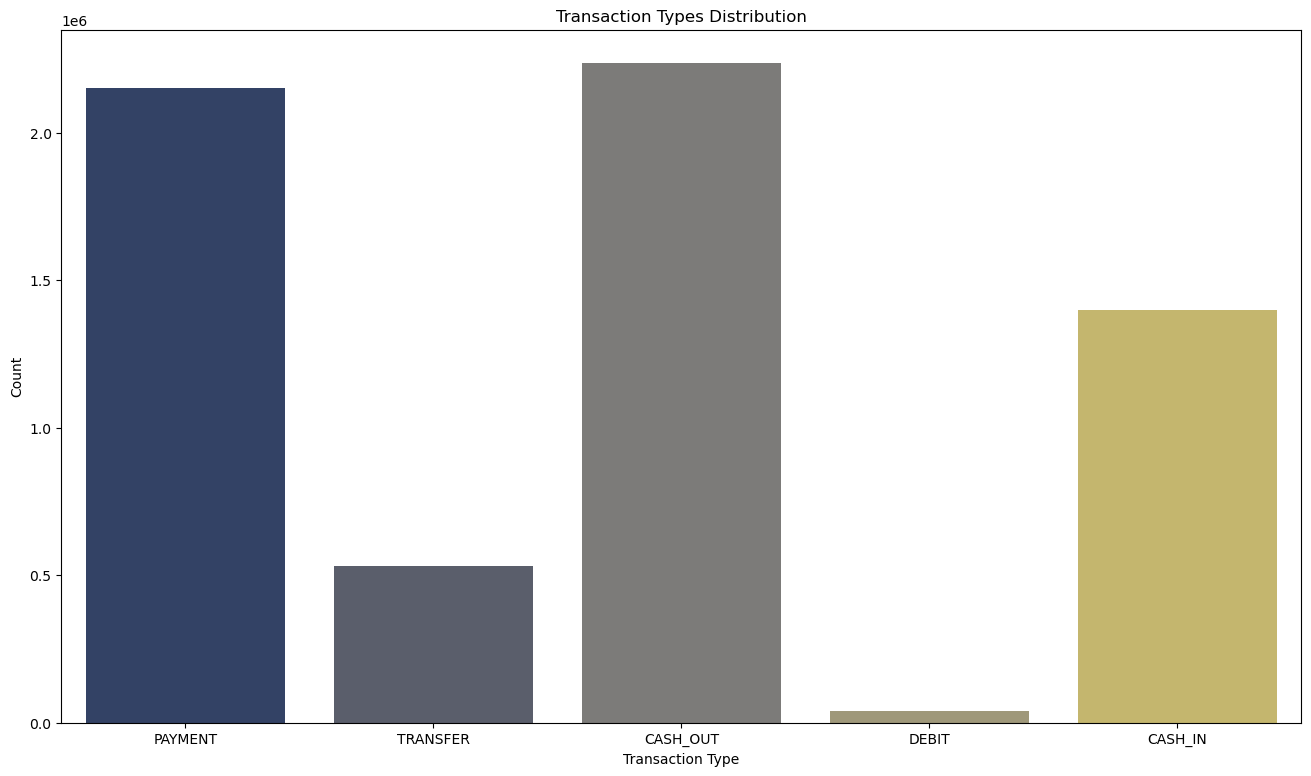

In [11]:
# Plotting the count of transaction types
plt.figure(figsize=(16, 9))
sns.countplot(x='type', data=df, palette='cividis')
plt.title('Transaction Types Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

In [12]:
# Percentage Distribution of Transaction Types
type_counts = df['type'].value_counts()
percentage_distribution = type_counts / len(df) * 100
print("Percentage Distribution of Transaction Types:")
print(percentage_distribution)

Percentage Distribution of Transaction Types:
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: type, dtype: float64


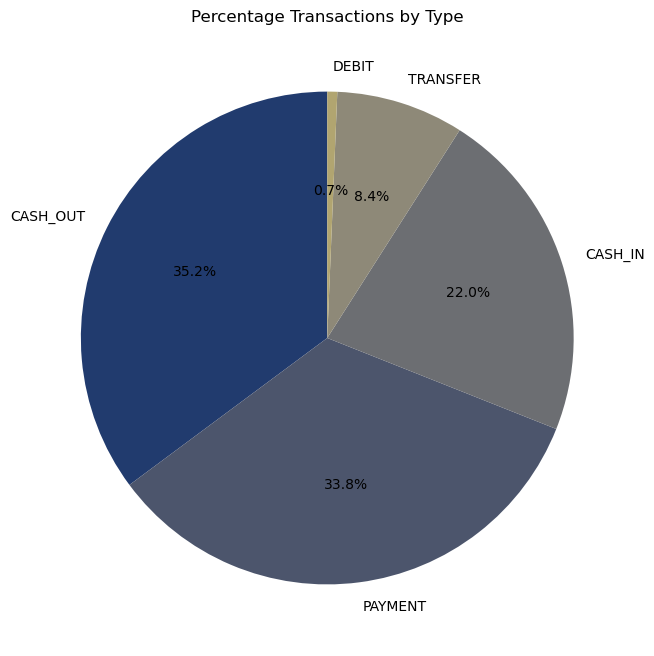

In [13]:
# Pie chart for the proportion of all transactions by type
plt.figure(figsize=(8, 8))
all_counts_by_type = df['type'].value_counts()
plt.pie(all_counts_by_type, labels=all_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('cividis'))
plt.title('Percentage Transactions by Type')
plt.show()

In [14]:
fraud_count = df["isFraud"].sum()
non_fraud_count = len(df) - fraud_count

print(f"Count of Fraud Transactions: {fraud_count:,.0f}")
print(f"Count of Non-fraud Transactions: {non_fraud_count:,.0f}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 6,354,407


In [15]:
fraud_percentage = df["isFraud"].mean() * 100
non_fraud_percentage = 100 - fraud_percentage

print(f"Fraud Transactions percentage: {fraud_percentage:.2f}%")
print(f"Non-fraud Transactions percentage: {non_fraud_percentage:.2f}%")

Fraud Transactions percentage: 0.13%
Non-fraud Transactions percentage: 99.87%


In [16]:
fraud_by_type = df[df["isFraud"] == 1].groupby("type").size()
print(fraud_by_type)


type
CASH_OUT    4116
TRANSFER    4097
dtype: int64


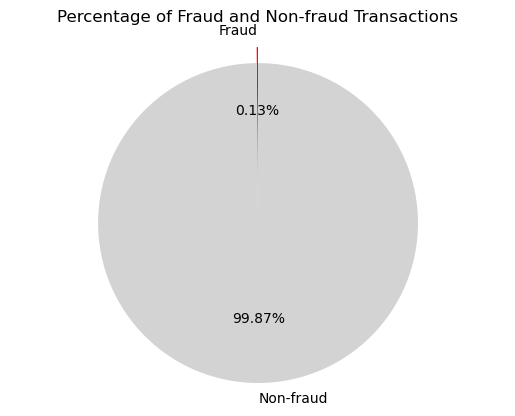

In [17]:
# Create a pie chart
labels = ['Fraud', 'Non-fraud']
sizes = [fraud_percentage, non_fraud_percentage]  # Use the correct variables
colors = ['red', 'lightgrey']
explode = (0.1, 0)  # Add some separation to the first slice (Fraud)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors, startangle=90, explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.title('Percentage of Fraud and Non-fraud Transactions')

# Show the plot
plt.show()

There are 8,213 fraud transactions and 6,354,407 non-fraud transactions in the dataset.
The percentage of fraud transactions is 0.13%, while non-fraud transactions constitute 99.87%.
Among the fraud transactions, CASH_OUT and TRANSFER are the predominant types, with 4,116 and 4,097 occurrences, respectively.

In [18]:
pd.set_option('display.float_format', '{:,.2f}'.format)

# Group by 'isFraud' and get statistics on the 'amount' column
amount_statistics = df.groupby('isFraud')['amount'].describe()

# Print the results
print("Statistics for non-fraud transactions:\n", amount_statistics.loc[0], "\n")
print("Statistics for fraud transactions:\n", amount_statistics.loc[1], )

Statistics for non-fraud transactions:
 count    6,354,407.00
mean       178,197.04
std        596,236.98
min              0.01
25%         13,368.40
50%         74,684.72
75%        208,364.76
max     92,445,516.64
Name: 0, dtype: float64 

Statistics for fraud transactions:
 count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: 1, dtype: float64


**Non-fraudulent transactions:** The average transaction amount for non-fraudulent transactions is approximately $178,197.04.

**Fraudulent transactions:** The average transaction amount for fraudulent transactions is significantly higher, approximately $1,467,967.30. This suggests that fraudulent transactions tend to involve larger amounts compared to non-fraudulent ones.

**Minimum and Maximum Transaction Amounts:**

**Non-fraudulent transactions:** The minimum transaction amount for non-fraudulent transactions is 0.01, and the maximum is 92,445,516.64.

**Fraudulent transactions:** The minimum transaction amount for fraudulent transactions is 0.00, and the maximum is 10,000,000.00.

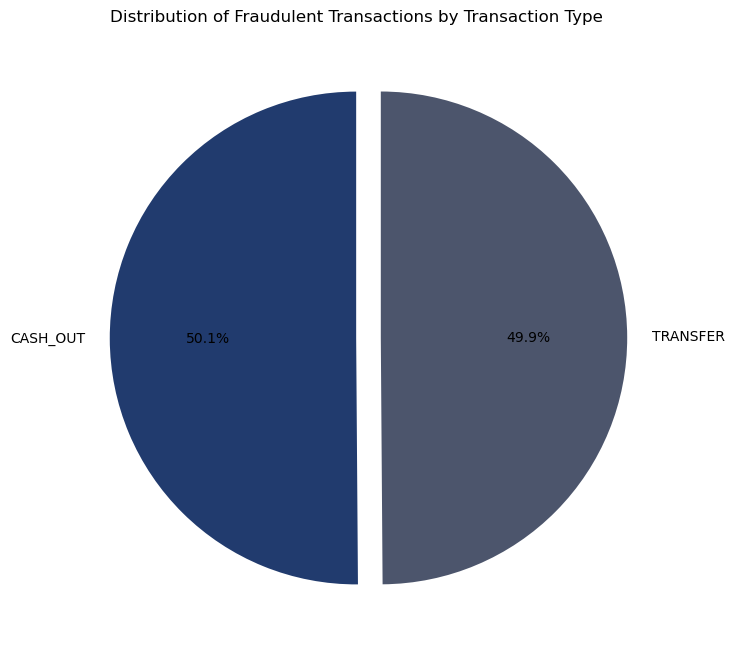

In [19]:
fraud_transactions = df[df["isFraud"] == 1]
fraud_counts_by_type = fraud_transactions.groupby("type").size()

plt.figure(figsize=(8, 8))
sns.set_palette('cividis')  # Set a pastel color palette
plt.pie(fraud_counts_by_type, labels=fraud_counts_by_type.index, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Distribution of Fraudulent Transactions by Transaction Type')
plt.show()

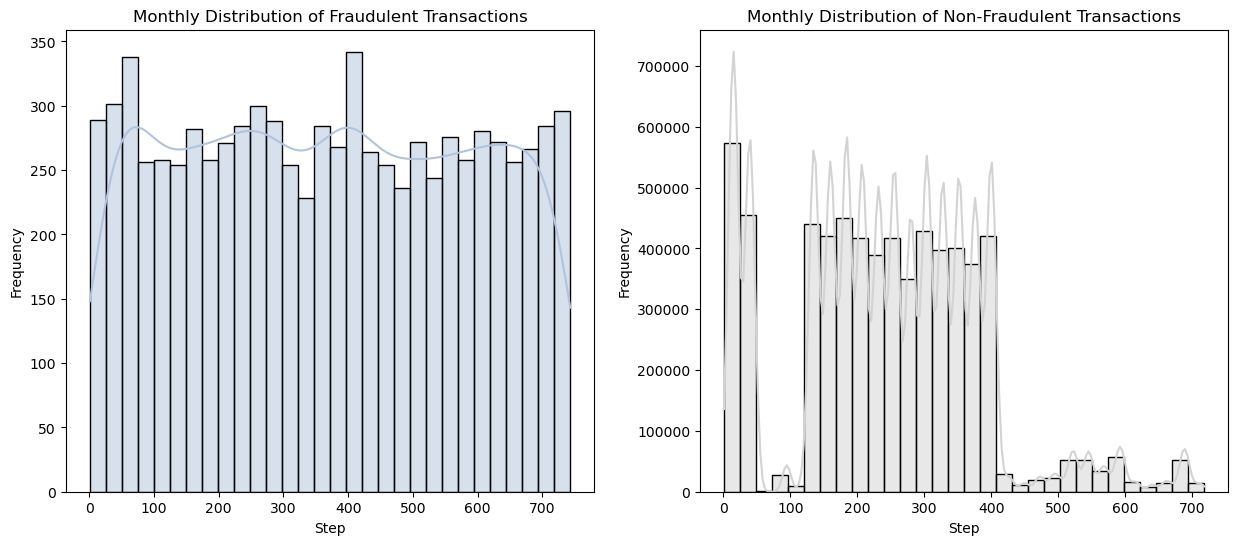

In [20]:
fraud_transactions = df[df['isFraud'] == 1]
non_fraud_transactions = df[df['isFraud'] == 0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Subplot for Fraudulent Transactions
sns.histplot(x='step', data=fraud_transactions, bins=30, kde=True, color='lightsteelblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Monthly Distribution of Fraudulent Transactions')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Frequency')

# Subplot for Non-Fraudulent Transactions
sns.histplot(x='step', data=non_fraud_transactions, bins=30, kde=True, color='lightgrey', edgecolor='black', ax=axes[1])
axes[1].set_title('Monthly Distribution of Non-Fraudulent Transactions')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Frequency')

# Show the plots
plt.show()


**Fraudulent Transactions Histogram (Left Plot):**

The left histogram shows the distribution of fraudulent transactions across different months (represented by the 'step' variable).
There is a relatively consistent height of bars across the bins, indicating a similar frequency of fraudulent transactions in each month.
The lack of pronounced peaks or valleys suggests that fraudulent activities do not exhibit distinct monthly patterns.

**Non-Fraudulent Transactions Histogram (Right Plot):**

The right histogram represents the distribution of non-fraudulent transactions over the months.
Unlike the fraudulent transactions, there are noticeable fluctuations in the heights of bars, indicating variations in the frequency of non-fraudulent transactions across different months.
These variations suggest potential temporal patterns, which may be influenced by factors such as business cycles, holidays, or economic trends.

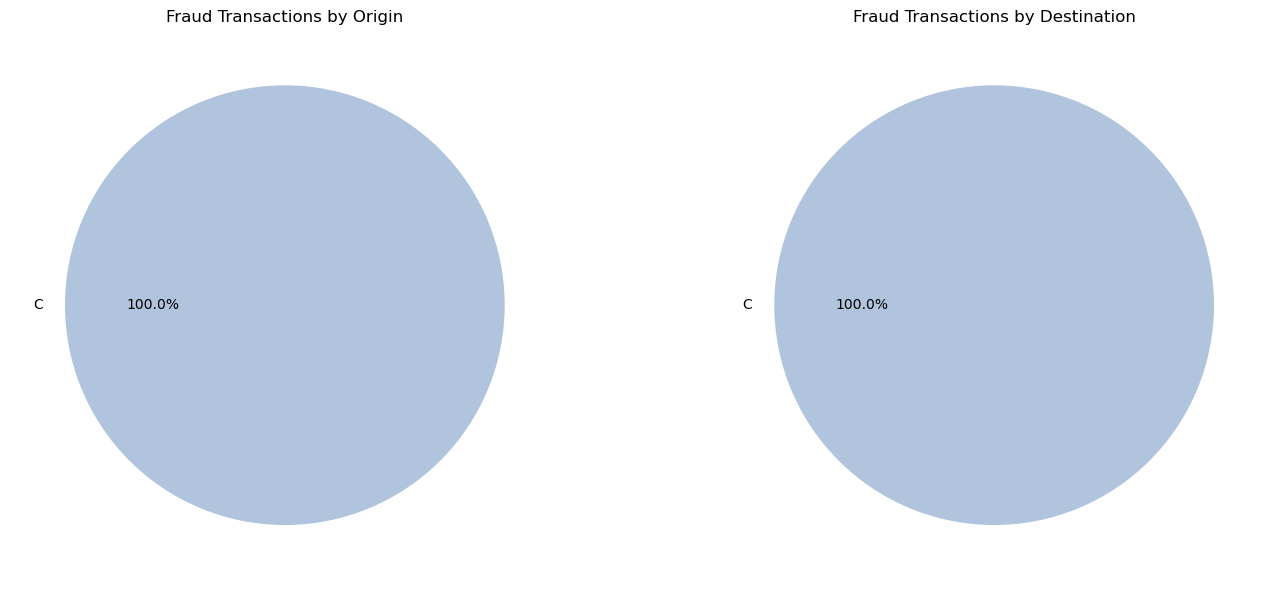

In [21]:
# Create a copy of the DataFrame containing only fraud transactions
fraud_transactions = df[df['isFraud'] == 1].copy()

# Extract the first letter of the 'nameOrig' and 'nameDest' columns
fraud_transactions['nameOrig_Str'] = fraud_transactions['nameOrig'].str[0]
fraud_transactions['nameDest_Str'] = fraud_transactions['nameDest'].str[0]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Define colors
lightsteelblue = 'lightsteelblue'
grey = 'grey'

# Plot for fraud transactions by origin
orig_counts = fraud_transactions['nameOrig_Str'].value_counts()
orig_percentages = orig_counts / orig_counts.sum() * 100
axes[0].pie(orig_percentages, labels=orig_percentages.index, autopct='%1.1f%%', colors=[lightsteelblue, grey])
axes[0].set_title('Fraud Transactions by Origin')

# Plot for fraud transactions by destination
dest_counts = fraud_transactions['nameDest_Str'].value_counts()
dest_percentages = dest_counts / dest_counts.sum() * 100
axes[1].pie(dest_percentages, labels=dest_percentages.index, autopct='%1.1f%%', colors=[lightsteelblue, grey])
axes[1].set_title('Fraud Transactions by Destination')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

The analysis reveals that 100% of the fraudulent transactions involve accounts categorized as customers, indicated by the designation 'C' in the dataset. This finding suggests that fraudulent activities predominantly occur within or involve customer accounts.

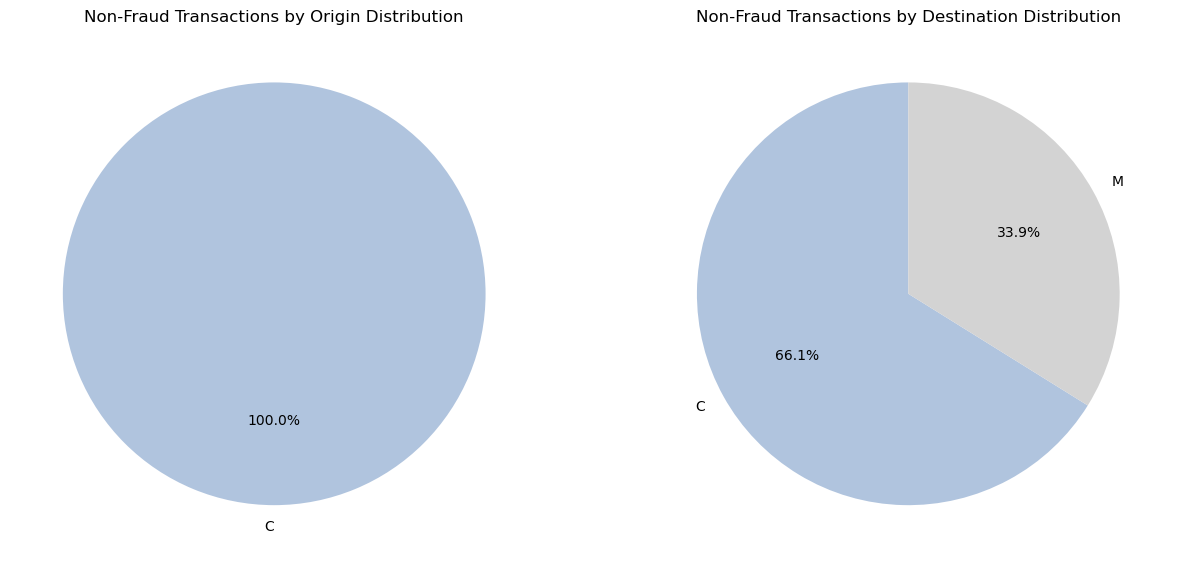

In [22]:
# Create a copy of the DataFrame containing only non-fraud transactions
non_fraud_transactions = df[df['isFraud'] == 0].copy()

# Extract the first letter of the 'nameOrig' and 'nameDest' columns
non_fraud_transactions['nameOrig_str'] = non_fraud_transactions['nameOrig'].str[0]
non_fraud_transactions['nameDest_str'] = non_fraud_transactions['nameDest'].str[0]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Pie chart for Non-Fraud Transactions by Origin with different colors
orig_counts_non_fraud = non_fraud_transactions['nameOrig_str'].value_counts()
orig_percentages_non_fraud = orig_counts_non_fraud / orig_counts_non_fraud.sum() * 100
axes[0].pie(orig_percentages_non_fraud, labels=orig_percentages_non_fraud.index, autopct='%1.1f%%', startangle=90, colors=['lightsteelblue', 'lightgrey'])
axes[0].set_title('Non-Fraud Transactions by Origin Distribution')

# Pie chart for Non-Fraud Transactions by Destination with different colors
dest_counts_non_fraud = non_fraud_transactions['nameDest_str'].value_counts()
dest_percentages_non_fraud = dest_counts_non_fraud / dest_counts_non_fraud.sum() * 100
axes[1].pie(dest_percentages_non_fraud, labels=dest_percentages_non_fraud.index, autopct='%1.1f%%', startangle=90, colors=['lightsteelblue', 'lightgrey'])
axes[1].set_title('Non-Fraud Transactions by Destination Distribution')

plt.show()

The analysis of non-fraud transactions reveals distinct patterns in both origin and destination distributions. In terms of origin distribution, 100% of non-fraud transactions originate from accounts classified as customers ('C'). This finding suggests that legitimate transactions predominantly involve customer accounts, highlighting the central role customers play in financial activities. On the other hand, the destination distribution unveils a more diverse landscape. While 66.1% of non-fraudulent transactions are directed towards customer accounts, the remaining 33.9% involve merchant accounts. This distribution indicates a significant portion of non-fraudulent transactions involve interactions with merchants, reflecting the financial activities beyond customer-to-customer transactions.

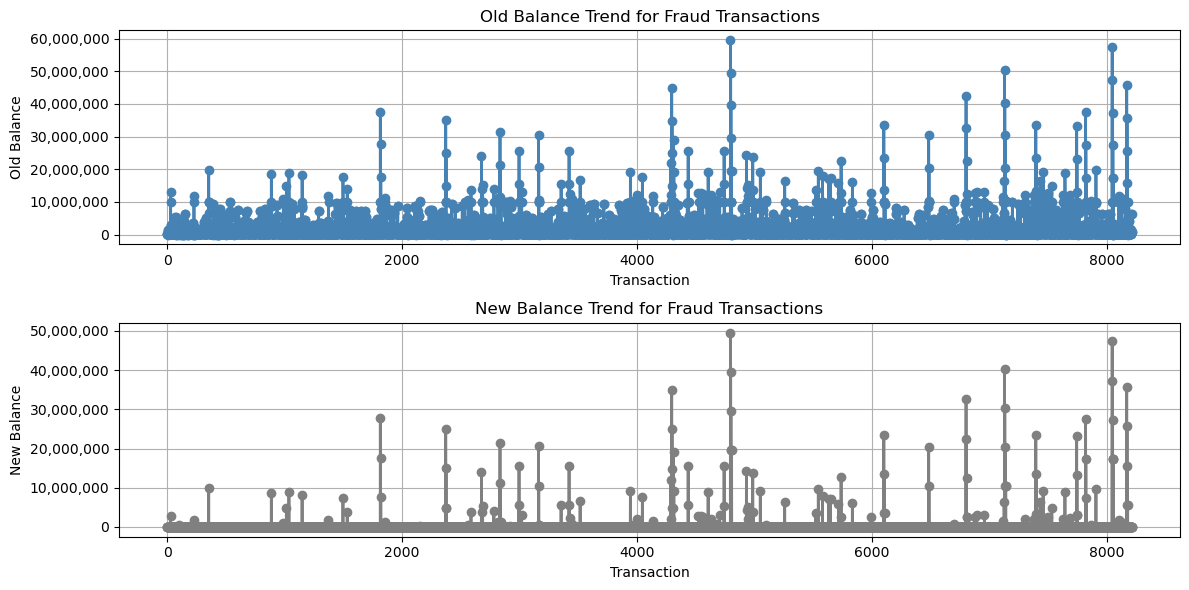

In [23]:
plt.figure(figsize=(12, 6))

# Plot for Old Balance
plt.subplot(2, 1, 1)
plt.plot(range(len(fraud_transactions)), fraud_transactions['oldbalanceOrig'], color='steelblue', marker='o', linestyle='-', linewidth=2)
plt.title('Old Balance Trend for Fraud Transactions')
plt.xlabel('Transaction')
plt.ylabel('Old Balance')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

# Plot for New Balance
plt.subplot(2, 1, 2)
plt.plot(range(len(fraud_transactions)), fraud_transactions['newbalanceOrig'], color='grey', marker='o', linestyle='-', linewidth=2)
plt.title('New Balance Trend for Fraud Transactions')
plt.xlabel('Transaction')
plt.ylabel('New Balance')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

The scatter plot depicts the relationship between the indices of transactions (on the x-axis) and the corresponding new balances of the origin account (on the y-axis) for fraud transactions.

The plots illustrate the trends in old and new balances for fraudulent transactions. In the old balance trend for fraud transactions, most of the data points cluster around the 0-10,000,000 range, indicating the initial balances before the transactions occur. However, in the new balance trend for fraud transactions, a considerable number of data points that initially had balances in the 10,000,000 range drop down to 0 after the transactions. This pattern suggests that fraudulent transactions often involve substantial initial balances that are drained to zero or significantly reduced, potentially indicating fraudulent activity such as fund transfers or withdrawals.

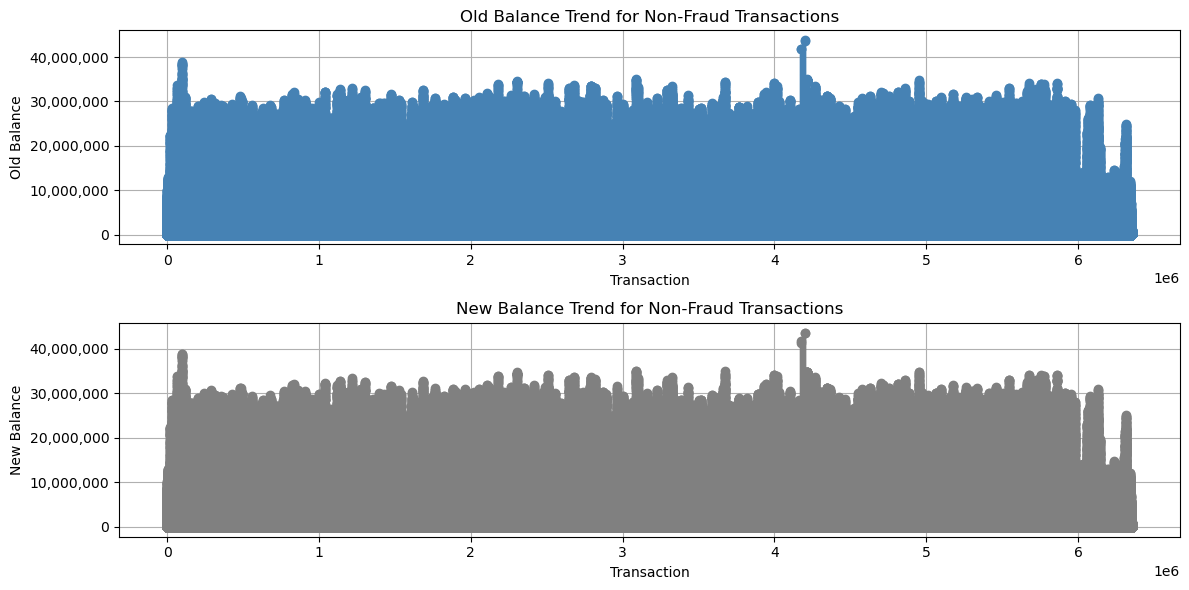

In [24]:
plt.figure(figsize=(12, 6))

# Plot for Old Balance
plt.subplot(2, 1, 1)
plt.plot(range(len(non_fraud_transactions)), non_fraud_transactions['oldbalanceOrig'], color='steelblue', marker='o', linestyle='-', linewidth=2)
plt.title('Old Balance Trend for Non-Fraud Transactions')
plt.xlabel('Transaction')
plt.ylabel('Old Balance')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

# Plot for New Balance
plt.subplot(2, 1, 2)
plt.plot(range(len(non_fraud_transactions)), non_fraud_transactions['newbalanceOrig'], color='grey', marker='o', linestyle='-', linewidth=2)
plt.title('New Balance Trend for Non-Fraud Transactions')
plt.xlabel('Transaction')
plt.ylabel('New Balance')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In the plots depicting the trends in old and new balances for non-fraudulent transactions, both charts demonstrate a consistent pattern. The old balance trend for non-fraud transactions displays varying balances across transactions, with fluctuations in the range of values. Similarly, the new balance trend for non-fraud transactions shows a diversity of outcomes after each transaction, with balances distributed across different levels. This suggests that non-fraudulent transactions involve a wide range of initial balances and result in diverse outcomes, reflecting the normal financial activities and operations within the dataset.

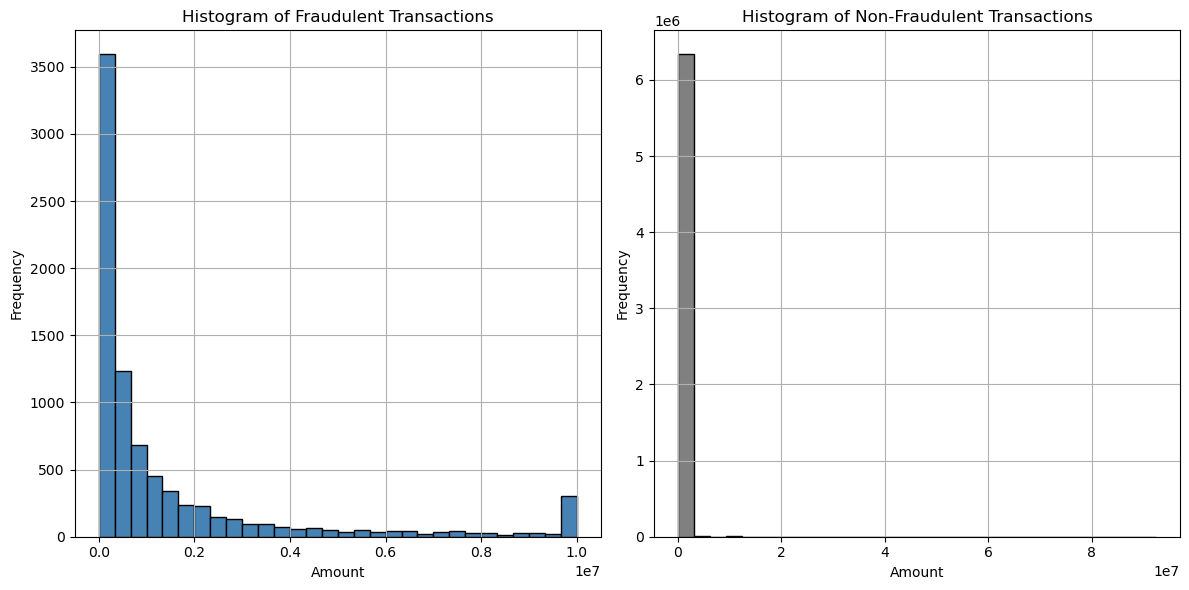

2               181.00
3               181.00
251           2,806.00
252           2,806.00
680          20,128.00
              ...     
6362615     339,682.13
6362616   6,311,409.28
6362617   6,311,409.28
6362618     850,002.52
6362619     850,002.52
Name: amount, Length: 8213, dtype: float64
0           9,839.64
1           1,864.28
4          11,668.14
5           7,817.71
6           7,107.77
             ...    
6362319     8,634.29
6362320   159,188.22
6362321   186,273.84
6362322    82,096.45
6362323     1,864.24
Name: amount, Length: 6354407, dtype: float64


In [25]:
# Separate fraudulent and non-fraudulent transactions
fraudulent_transactions = df[df['isFraud'] == 1]['amount']
non_fraudulent_transactions = df[df['isFraud'] == 0]['amount']

# Create subplots for fraudulent and non-fraudulent transactions
plt.figure(figsize=(12, 6))

# Plot histogram for fraudulent transactions
plt.subplot(1, 2, 1)
plt.hist(fraudulent_transactions, bins=30, color='steelblue', edgecolor='black')
plt.title('Histogram of Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)

# Plot histogram for non-fraudulent transactions
plt.subplot(1, 2, 2)
plt.hist(non_fraudulent_transactions, bins=30, color='grey', edgecolor='black')
plt.title('Histogram of Non-Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()
print(fraudulent_transactions)
print(non_fraudulent_transactions)

**Fraudulent Transactions:**

The histogram displays various bars, indicating a wide range of transaction amounts related to fraudulent activities, spanning from small to potentially large sums.
The fraudulent transactions range from 181.00 to 6,311,409.28, showing the diverse nature of fraudulent behaviors in financial transactions.

**Non-Fraudulent Transactions:**

In contrast, the histogram for non-fraudulent transactions shows only one bar, representing the entire range of transaction amounts.
Non-fraudulent transactions appear more consistent in terms of the amounts involved, with the majority falling within a single bin.
Overall, fraudulent transactions exhibit a broader spectrum of transaction amounts compared to non-fraudulent transactions. These histograms help visualize the patterns and distributions of transaction amounts, aiding in the detection and analysis of fraudulent activities.

Non-fraudulent transactions span from 1,864.24 to 6,311,409.28, with transactions clustering mostly within lower to moderate amounts, such as 9,839.64 and 11,668.14.



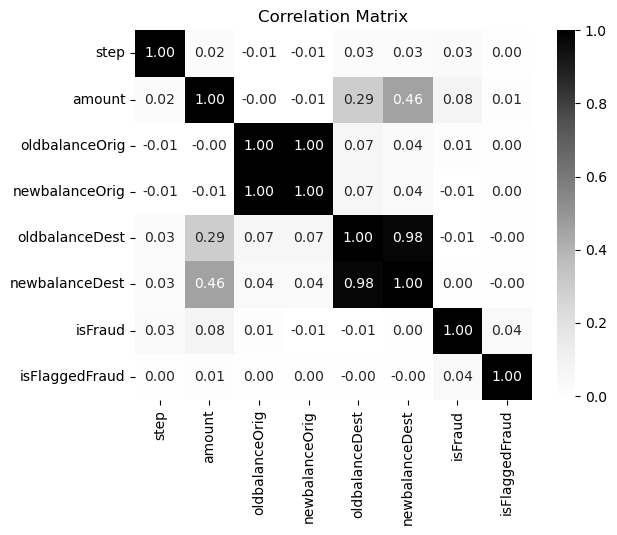

In [26]:
# Correlation Matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greys', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The correlation matrix provides insights into the linear relationships between numerical features. It helps identify multicollinearity and understand how features are correlated. 

In [27]:
print(correlation_matrix)

                step  amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  \
step            1.00    0.02           -0.01           -0.01            0.03   
amount          0.02    1.00           -0.00           -0.01            0.29   
oldbalanceOrig -0.01   -0.00            1.00            1.00            0.07   
newbalanceOrig -0.01   -0.01            1.00            1.00            0.07   
oldbalanceDest  0.03    0.29            0.07            0.07            1.00   
newbalanceDest  0.03    0.46            0.04            0.04            0.98   
isFraud         0.03    0.08            0.01           -0.01           -0.01   
isFlaggedFraud  0.00    0.01            0.00            0.00           -0.00   

                newbalanceDest  isFraud  isFlaggedFraud  
step                      0.03     0.03            0.00  
amount                    0.46     0.08            0.01  
oldbalanceOrig            0.04     0.01            0.00  
newbalanceOrig            0.04    -0.01        

New Balances and Old Balances in Destination Accounts (0.98). Strong positive correlation accounts with higher old balances tend to have higher new balances in subsequent transactions as expected.

The heatmap lacks strong correlations with fraud (isFraud). Although individual features may not strongly predict fraud (correlation with isFraud of 0.01), exploring feature relationships can refine feature engineering and enhance fraud detection algorithms.



# Data Processing 

In [28]:
# Data Processing
processing = df.copy().drop(['isFlaggedFraud', 'nameDest', 'nameOrig'], axis=1)
void = ['CASH_IN', 'DEBIT', 'PAYMENT']
processing = processing[~processing['type'].isin(void)]


In [29]:
# Calculate percentages before correction
total_entries_before_correction = len(processing)
wrong_org_balance_count_before_correction = sum(processing["oldbalanceOrig"] - processing["amount"] != processing["newbalanceOrig"])
wrong_dest_balance_count_before_correction = sum(processing["oldbalanceDest"] + processing["amount"] != processing["newbalanceDest"])
percentage_wrong_org_balance_before_correction = (wrong_org_balance_count_before_correction / total_entries_before_correction) * 100
percentage_wrong_dest_balance_before_correction = (wrong_dest_balance_count_before_correction / total_entries_before_correction) * 100

# Print results before correction
print("Before Correction:")
print(f"Total Entries: {total_entries_before_correction}")
print(f"Percentage of transactions with incorrect origin balances: {percentage_wrong_org_balance_before_correction:.2f}%")
print(f"Percentage of transactions with incorrect destination balances: {percentage_wrong_dest_balance_before_correction:.2f}%\n")

# Identify and correct wrong origin balances
processing.loc[(processing["oldbalanceOrig"] == 0) | (processing["oldbalanceOrig"] < processing["amount"]), "oldbalanceOrig"] = processing["amount"]
processing["newbalanceOrig"] = processing["oldbalanceOrig"] - processing["amount"]

# Correct destination balances
processing["newbalanceDest"] = processing["oldbalanceDest"] + processing["amount"]

# Calculate percentages after correction
total_entries_after_correction = len(processing)
wrong_org_balance_count_after_correction = sum(processing["oldbalanceOrig"] - processing["amount"] != processing["newbalanceOrig"])
wrong_dest_balance_count_after_correction = sum(processing["oldbalanceDest"] + processing["amount"] != processing["newbalanceDest"])
percentage_wrong_org_balance_after_correction = (wrong_org_balance_count_after_correction / total_entries_after_correction) * 100
percentage_wrong_dest_balance_after_correction = (wrong_dest_balance_count_after_correction / total_entries_after_correction) * 100

#Results after correction
print("After Correction:")
print(f"Total Entries: {total_entries_after_correction}")
print(f"Percentage of transactions with incorrect origin balances: {percentage_wrong_org_balance_after_correction:.2f}%")
print(f"Percentage of transactions with incorrect destination balances: {percentage_wrong_dest_balance_after_correction:.2f}%")

Before Correction:
Total Entries: 2770409
Percentage of transactions with incorrect origin balances: 93.72%
Percentage of transactions with incorrect destination balances: 42.09%

After Correction:
Total Entries: 2770409
Percentage of transactions with incorrect origin balances: 0.00%
Percentage of transactions with incorrect destination balances: 0.00%


In the data processing phase, performs data processing tasks on a financial transaction dataset. Initially, the dataset is copied and irrelevant columns such as 'isFlaggedFraud', 'nameDest', and 'nameOrig' are dropped. Additionally, transactions categorized as 'CASH_IN', 'DEBIT', and 'PAYMENT' are filtered out to focus on relevant transaction types.

Subsequently, the code calculates the percentages of transactions with incorrect origin and destination balances before any correction. It identifies transactions where the old balance of the origin account or the destination account does not align with the transaction amount and adjusts these balances accordingly. After the correction, the code recalculates the percentages of transactions with incorrect origin and destination balances.

Before the correction, a significant percentage of transactions exhibit inconsistencies in their origin and destination balances. However, after the correction process, the percentages of transactions with incorrect balances reduce to zero. This data correction is crucial for ensuring the integrity and accuracy of the financial transaction dataset, which is important for subsequent analysis and modeling tasks, particularly in fraud detection applications. 

# Feature Engineering

In [30]:
#LabelEncoder for the 'type' column
label_encoder = LabelEncoder()
processing['type'] = label_encoder.fit_transform(processing['type'])


In [31]:
X = processing[['step', 'type', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
Y = processing['isFraud']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


The feature engineering process involved encoding the categorical feature 'type' into numerical values using LabelEncoder from scikit-learn. This transformation enables machine learning algorithms to effectively process the 'type' column representing transaction types. The dataset was divided into feature variables (X) and the target variable (Y), including features like 'step' (time), 'amount' (transaction amount), 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest'. The target variable Y represents fraud status. The data was split into 80% for training and 20% for testing using train_test_split, setting the stage for building and evaluating fraud detection models.


# Modeling


In this project, four machine learning algorithms such as Logistic Regression, Random Forest, XGBoost, and LightGBM are being implemented. To optimize these models, hyperparameter tuning techniques like GridSearchCV and RandomizedSearchCV are applied. The best-performing models are identified using the best_estimator_ attribute. The objective is to evaluate and compare these models to ascertain the most effective one for fraud detection within the dataset.The goal is to compare and contrast these models to determine which one performs best for this dataset, particularly in the context of fraud detection.


**Logistic Regression**

Logistic Regression using two different sampling techniques: SMOTE (Synthetic Minority Over-sampling Technique) and undersampling. SMOTE aims to address class imbalance by generating synthetic samples for the minority class, while undersampling reduces the majority class instances to balance the dataset. Conducted hyperparameter tuning using GridSearchCV to optimize the Logistic Regression model's performance.

In [32]:
# Initialize Logistic Regression model
logistic_regression = LogisticRegression(random_state=42)

In [33]:
# Define oversampling and undersampling strategies
oversampler = SMOTE(sampling_strategy=0.1, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)

# Apply SMOTE for oversampling
X_train_smote, Y_train_smote = oversampler.fit_resample(X_train, Y_train)

# Apply RandomUnderSampler for undersampling
X_train_undersampled, Y_train_undersampled = undersampler.fit_resample(X_train, Y_train)

In [34]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}
#Define Metrics using make_scorer
scoring = {
    'F1': make_scorer(f1_score),
    'ROC-AUC': make_scorer(roc_auc_score),
    'Recall': make_scorer(recall_score)
}





In [35]:
# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Only 'l2' penalty is compatible with the 'lbfgs' solver

In [36]:
# Perform Grid Search CV for hyperparameter tuning with SMOTE
grid_search_smote = GridSearchCV(logistic_regression, param_grid=param_grid, cv=skf, scoring=scoring, refit='F1')
grid_search_smote.fit(X_train_smote, Y_train_smote)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='F1',
             scoring={'F1': make_scorer(f1_score),
                      'ROC-AUC': make_scorer(roc_auc_score),
                      'Recall': make_scorer(recall_score)})

In [37]:
# Perform Grid Search CV for hyperparameter tuning with undersampling
grid_search_undersampling = GridSearchCV(logistic_regression, param_grid=param_grid, cv=skf, scoring=scoring, refit='F1')
grid_search_undersampling.fit(X_train_undersampled, Y_train_undersampled)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='F1',
             scoring={'F1': make_scorer(f1_score),
                      'ROC-AUC': make_scorer(roc_auc_score),
                      'Recall': make_scorer(recall_score)})

In [38]:
# Get the best model and its parameters for SMOTE
best_logistic_regression_smote = grid_search_smote.best_estimator_

# Get the best model and its parameters for undersampling
best_logistic_regression_undersampling = grid_search_undersampling.best_estimator_



In [39]:
# Make predictions on the test set for SMOTE using the best model
Y_pred_smote = best_logistic_regression_smote.predict(X_test)
Y_pred_proba_smote = best_logistic_regression_smote.predict_proba(X_test)[:, 1]

In [40]:
# Make predictions on the test set for undersampling using the best model
Y_pred_undersampling = best_logistic_regression_undersampling.predict(X_test)
Y_pred_proba_undersampling = best_logistic_regression_undersampling.predict_proba(X_test)[:, 1]


In [41]:
# Evaluate the models
print("Evaluation Metrics for SMOTE:")
print(classification_report(Y_test, Y_pred_smote))
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred_proba_smote))
print("F1 Score:", f1_score(Y_test, Y_pred_smote))
print("Recall Score:", recall_score(Y_test, Y_pred_smote))

print("\nEvaluation Metrics for Undersampling:")
print(classification_report(Y_test, Y_pred_undersampling))
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred_proba_undersampling))
print("F1 Score:", f1_score(Y_test, Y_pred_undersampling))
print("Recall Score:", recall_score(Y_test, Y_pred_undersampling))


Evaluation Metrics for SMOTE:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552439
           1       0.03      0.20      0.05      1643

    accuracy                           0.98    554082
   macro avg       0.51      0.59      0.52    554082
weighted avg       0.99      0.98      0.99    554082

ROC AUC Score: 0.6547842903483931
F1 Score: 0.04674505305420132
Recall Score: 0.19841752891052952

Evaluation Metrics for Undersampling:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552439
           1       0.03      0.19      0.05      1643

    accuracy                           0.98    554082
   macro avg       0.51      0.59      0.52    554082
weighted avg       0.99      0.98      0.99    554082

ROC AUC Score: 0.6553419270388332
F1 Score: 0.0467234792829856
Recall Score: 0.1935483870967742


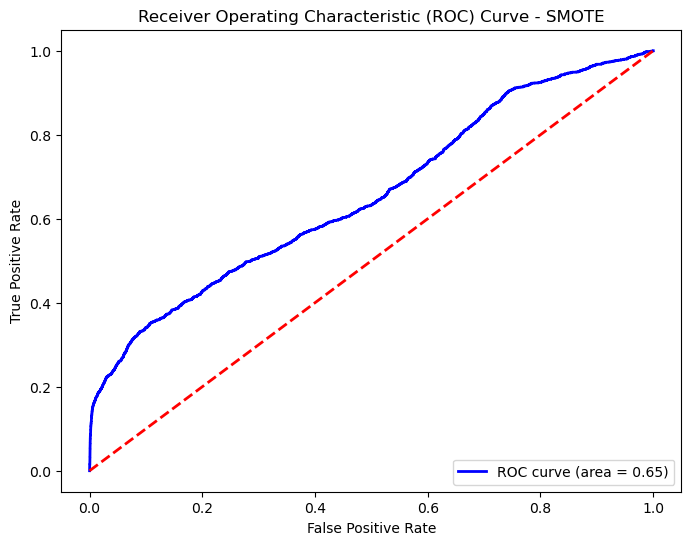

In [42]:
# Plot ROC curve for SMOTE model
fpr_smote, tpr_smote, _ = roc_curve(Y_test, Y_pred_proba_smote)
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote, tpr_smote, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, Y_pred_proba_smote))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SMOTE')
plt.legend(loc="lower right")
plt.show()

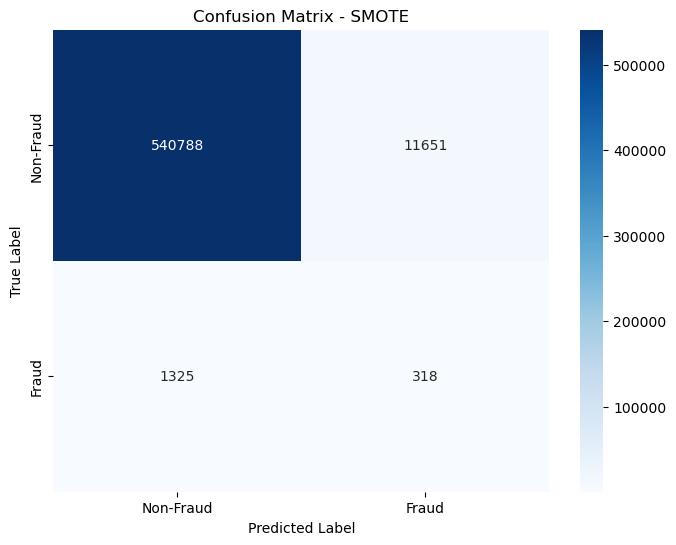

[[540788  11651]
 [  1325    318]]


In [43]:
# Calculate the confusion matrix for SMOTE model
cm_smote = confusion_matrix(Y_test, Y_pred_undersampling)

# Plot Confusion Matrix for SMOTE model using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(cm_smote)

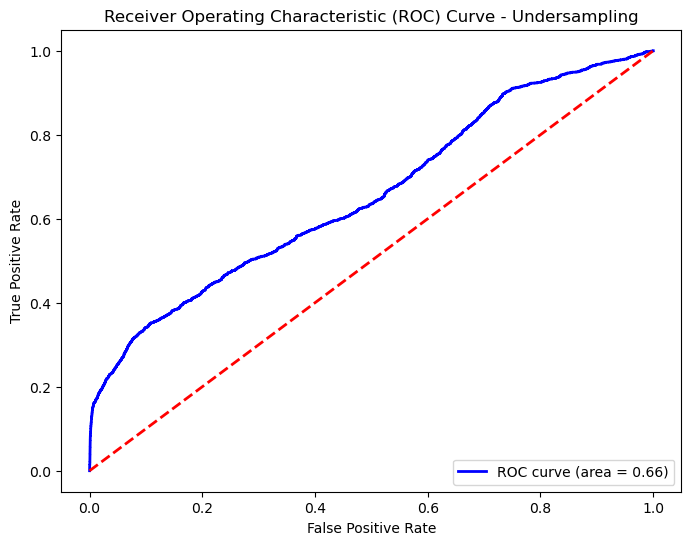

In [44]:
# Plot ROC curve for Undersampling model
fpr_undersampling, tpr_undersampling, _ = roc_curve(Y_test, Y_pred_proba_undersampling)
plt.figure(figsize=(8, 6))
plt.plot(fpr_undersampling, tpr_undersampling, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, Y_pred_proba_undersampling))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Undersampling')
plt.legend(loc="lower right")
plt.show()

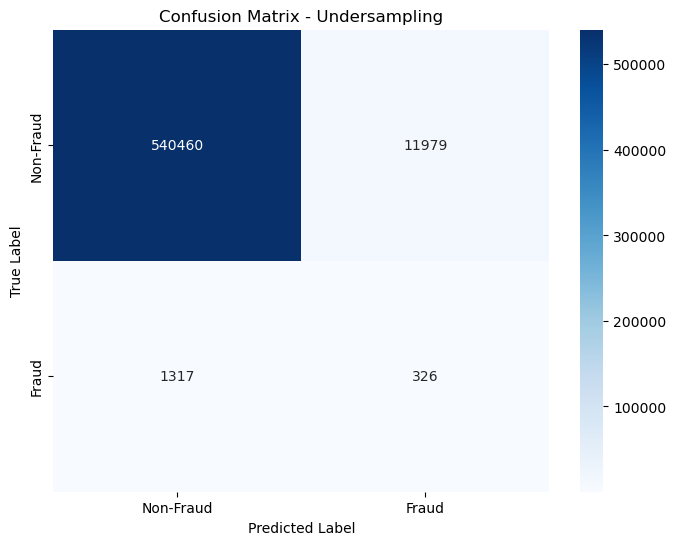

[[540460  11979]
 [  1317    326]]


In [45]:
# Plot Confusion Matrix for Undersampling model using seaborn heatmap
# Calculate the confusion matrix for SMOTE model
cm_undersampling = confusion_matrix(Y_test, Y_pred_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_undersampling, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Undersampling')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(cm_undersampling)

Both models exhibit similar performance in terms of precision, recall, and F1-score.
However, neither model performs well in identifying fraudulent transactions, as indicated by the low recall scores (20% for SMOTE and 19% for Undersampling).The ROC AUC scores suggest that both models have moderate discriminatory power between fraudulent and non-fraudulent transactions.The models struggle to accurately detect fraudulent transactions, indicating the challenges of dealing with imbalanced datasets in fraud detection.

Improvement in recall, precision, and overall model performance is necessary to enhance the effectiveness of fraud detection algorithms.





**Random Forest**

Continuing with using undersampled data helps in spotting fraudulent transactions more effectively. Since only a small percentage of transactions are fraudulent, there's an issue of imbalance where models might focus too much on non-fraudulent cases. Undersampling helps balance this by ensuring an equal mix of both types during training. This improves the model's ability to identify fraud, reduces the risk of biased predictions, and makes the model more efficient in using computer resources.

This approach also makes the model more sensitive to detecting fraud, which is crucial for accurate fraud detection. Additionally, undersampling streamlines the training process.

In [46]:
# Initialize Random Forest model with balanced class weights
random_forest = RandomForestClassifier(random_state=42)



In [47]:
# Define parameter grid for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']  
}

scoring = {
    'F1': make_scorer(f1_score),
    'ROC_AUC': make_scorer(roc_auc_score),
    'Recall': make_scorer(recall_score)
}

In [48]:
# Perform Randomized Search CV for hyperparameter tuning with Random Forest
random_search_rf = RandomizedSearchCV(random_forest, param_distributions=param_grid_rf, n_iter=10, scoring=scoring, refit='F1', cv=skf)

# Fit the Randomized Search CV on the undersampled data
random_search_rf.fit(X_train_undersampled, Y_train_undersampled)




RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'max_depth': [None, 10],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   refit='F1',
                   scoring={'F1': make_scorer(f1_score),
                            'ROC_AUC': make_scorer(roc_auc_score),
                            'Recall': make_scorer(recall_score)})

In [49]:
# Get the best model 
best_random_forest = random_search_rf.best_estimator_

# Make predictions on the test set using the best Random Forest model
Y_pred_rf = best_random_forest.predict(X_test)
Y_pred_proba_rf = best_random_forest.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
print("\nEvaluation Metrics for Random Forest:")
print(classification_report(Y_test, Y_pred_rf))
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred_proba_rf))
print("F1 Score:", f1_score(Y_test, Y_pred_rf))
print("Recall Score:", recall_score(Y_test, Y_pred_rf))


Evaluation Metrics for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    552439
           1       0.08      0.79      0.15      1643

    accuracy                           0.97    554082
   macro avg       0.54      0.88      0.57    554082
weighted avg       1.00      0.97      0.98    554082

ROC AUC Score: 0.9539917664319019
F1 Score: 0.1468345851922968
Recall Score: 0.7912355447352404


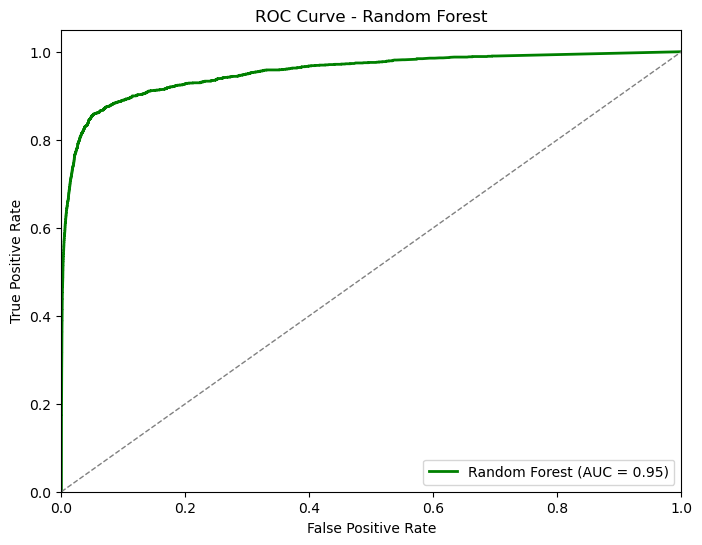

In [50]:
# Plot ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred_proba_rf)
roc_auc_rf = roc_auc_score(Y_test, Y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()




The Random Forest model, trained on undersampled data to address the imbalance between fraudulent and non-fraudulent transactions, significantly improved fraud detection compared to logistic regression. With a recall score of 79%, Random Forest outperformed logistic regression in identifying actual fraudulent cases, though with lower precision. The model achieved an F1 score of 0.15 and an accuracy of 97%, indicating its effectiveness in classifying fraudulent transactions while maintaining reasonable precision. Additionally, the ROC AUC score of 0.95 demonstrates the model's ability to distinguish between fraudulent and non-fraudulent transactions. 

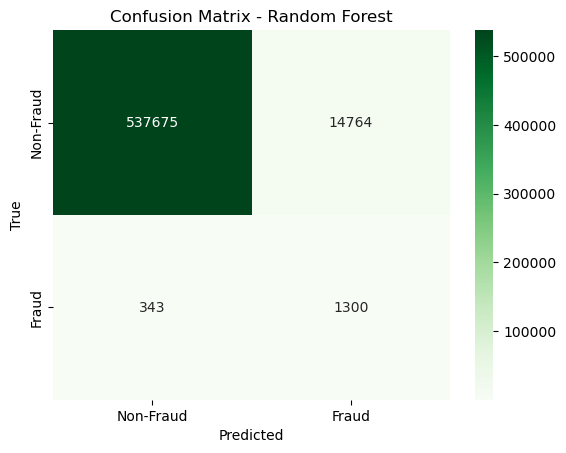

[[537675  14764]
 [   343   1300]]


In [51]:
# Plot confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

print(conf_matrix_rf)


In the confusion matrix for the Random Forest model, it shows that out of 552,082 transactions, 537,675 non-fraudulent transactions were correctly classified (True Negatives), while 14,764 non-fraudulent transactions were incorrectly classified as fraudulent (False Positives). On the other hand, the model successfully identified 1,300 fraudulent transactions (True Positives) but missed 343 fraudulent transactions (False Negatives). This confusion matrix illustrates the trade-off between precision and recall, where the model excels in identifying actual fraud cases but has a relatively higher rate of false positives.



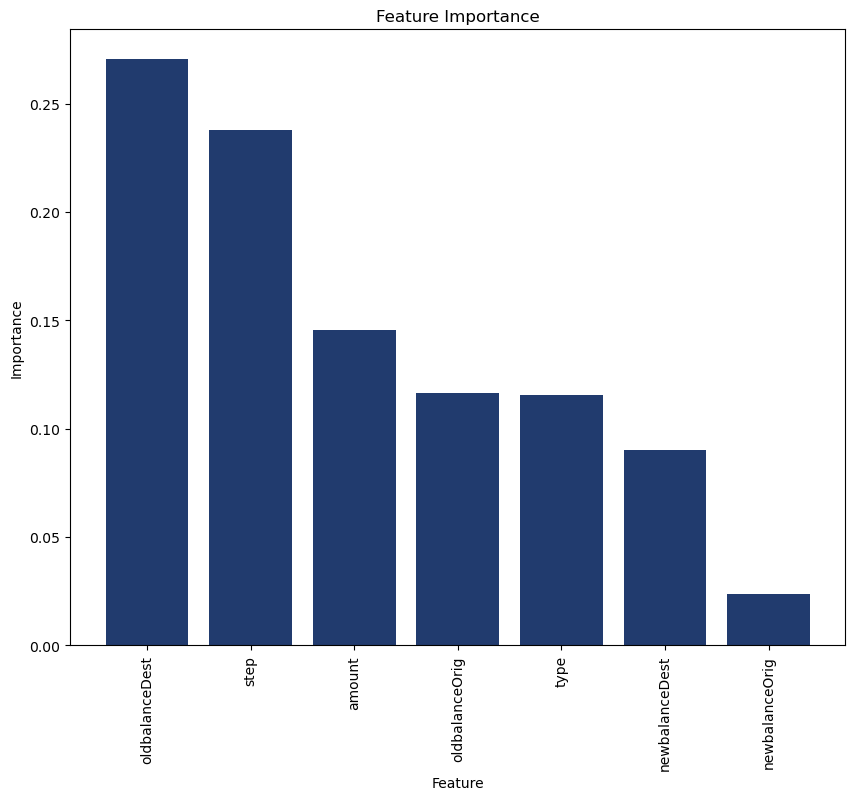

In [52]:
# Plot feature importance
feature_importances = best_random_forest.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))
plt.bar(range(X_train_undersampled.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X_train_undersampled.shape[1]), X_train_undersampled.columns[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()


In [53]:
# Print confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
print("Confusion Matrix - Random Forest:")
print(conf_matrix_rf)

# Print feature importance
feature_importances = best_random_forest.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

print("\nFeature Importance - Random Forest:")
for i in range(len(sorted_idx)):
    print(f"{X_train_undersampled.columns[sorted_idx[i]]}: {feature_importances[sorted_idx[i]]}")

Confusion Matrix - Random Forest:
[[537675  14764]
 [   343   1300]]

Feature Importance - Random Forest:
oldbalanceDest: 0.270681714689889
step: 0.2375581314650731
amount: 0.1456101591974765
oldbalanceOrig: 0.11652903652604292
type: 0.1154097373072829
newbalanceDest: 0.09031307803156767
newbalanceOrig: 0.023898142782667768


In the Random Forest model, feature analysis highlights key factors influencing fraud detection. Specifically, the oldbalanceDest feature holds the highest importance, suggesting the significance of previous destination account balances in predicting fraud. The timing of transactions (step) closely follows, underscoring the temporal aspect's relevance in fraud identification. Additionally, transaction amount and type also play significant roles, indicating that larger transactions and specific types may signal potential fraud.

By considering various features such as old and new balances, transaction amount, and type, Random Forest offers a reliable approach to fraud detection in financial transactions. This contrasts with logistic regression, which may struggle with imbalanced datasets and capturing complex feature relationships.

**XGBoost**

In [68]:
# Define the XGBClassifier with adjustments for imbalanced data
xgb = XGBClassifier(random_state=42)



In [69]:
# parameter distributions for Randomized Search
param_dist_xgb = {
    'n_estimators': randint(200, 1000),  
    'max_depth': randint(3, 10),         
    'learning_rate': uniform(0.01, 0.3),  
    'subsample': [0.6, 0.8, 1.0],         
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'gamma': [0, 0.1, 0.2, 0.3],          
    'scale_pos_weight': [1, 2, 3, 4]     
}

scoring = {
    'F1': make_scorer(f1_score),
    'ROC_AUC': make_scorer(roc_auc_score),
    'Recall': make_scorer(recall_score)
}

# Perform Randomized Search CV with adjusted parameters
random_search_xgb = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist_xgb, 
    n_iter=10, 
    cv=skf, 
    scoring=scoring, 
    refit='F1', 
    random_state=42,
    return_train_score=True,
    n_jobs=-1  # Utilize multiple CPU cores for parallelism
)

In [70]:
# Fit the Randomized Search CV on the undersampled data
random_search_xgb.fit(X_train_undersampled, Y_train_undersampled)



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8ed5f05700>,
                                        'n_esti

In [ ]:
best_xgb = random_search_xgb.best_estimator_
best_score_xgb = random_search_xgb.best_score_

# Make predictions using the best model
Y_pred_xgb = best_xgb.predict(X_test)
Y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
print("\nEvaluation Metrics for XGBoost with Undersampling:")
print(classification_report(Y_test, Y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred_proba_xgb))
print("F1 Score:", f1_score(Y_test, Y_pred_xgb))
print("Recall Score:", recall_score(Y_test, Y_pred_xgb))



Evaluation Metrics for XGBoost with Undersampling:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.16      0.82      0.27      1643

    accuracy                           0.99    554082
   macro avg       0.58      0.91      0.63    554082
weighted avg       1.00      0.99      0.99    554082

ROC AUC Score: 0.9729033417973687
F1 Score: 0.274597223629547
Recall Score: 0.8247108947048083


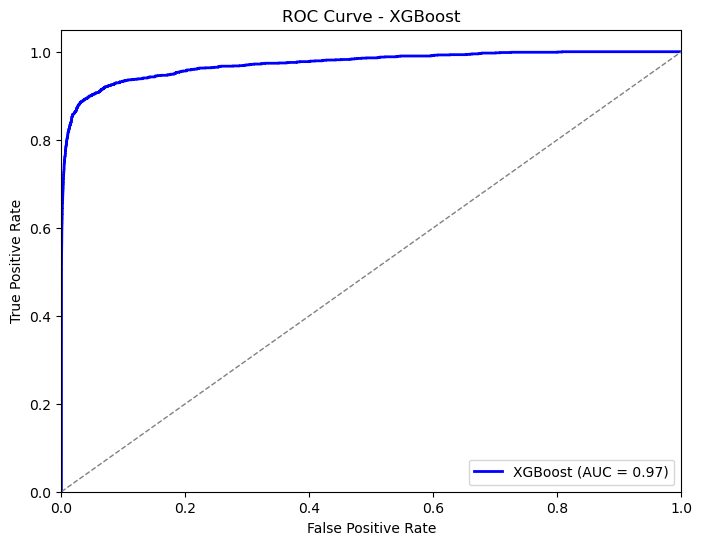

In [ ]:
# Plot ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(Y_test, Y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(Y_test, Y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

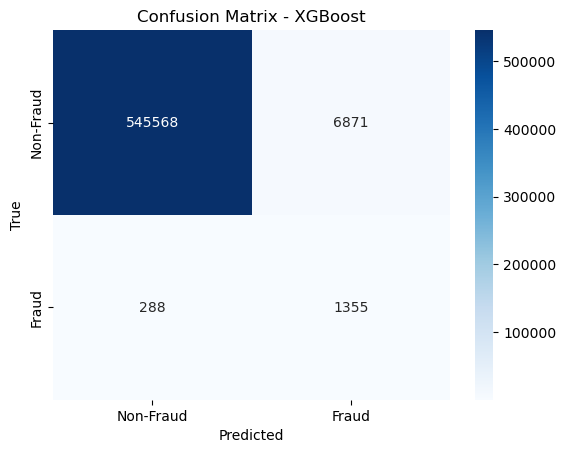

Confusion Matrix - XGBoost:
[[545568   6871]
 [   288   1355]]


In [ ]:
# Plot confusion matrix for XGBoost
conf_matrix_xgb = confusion_matrix(Y_test, Y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

print("Confusion Matrix - XGBoost:")
print(conf_matrix_xgb)

In the assessment of fraud detection models, Logistic Regression demonstrated interpretability but struggled with complex patterns, resulting in lower recall and F1 scores than Random Forest. While Random Forest excelled in managing imbalanced data, XGBoost outperformed both models with the highest recall and F1 scores, along with an impressive ROC AUC of 0.97. XGBoost's 82% recall and F1 score of 0.27, displaying accuracy in identifying fraudulent transactions. This underscores XGBoost's effectiveness in handling complex data structures, making it the preferred choice for fraud detection over Logistic Regression and Random Forest.

**LightGBM**

In [ ]:
# Define the LightGBM Classifier
lgbm = LGBMClassifier(random_state=42)

In [ ]:
# parameter distributions for Randomized Search
param_dist_lgbm = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'num_leaves': randint(20, 150),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

scoring = {
    'F1': make_scorer(f1_score),
    'ROC_AUC': make_scorer(roc_auc_score),
    'Recall': make_scorer(recall_score)
}

# Randomized Search CV with adjusted parameters
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=skf,
    scoring=scoring,
    refit='F1',
    random_state=42,
    return_train_score=True,
    n_jobs=-1  
)


In [ ]:
# Fit the Randomized Search CV on the undersampled data
random_search_lgbm.fit(X_train_undersampled, Y_train_undersampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8e951d4b50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen objec...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8ed6840340>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8ed73b9250>,
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.8, 1.0]},
                   ran

In [ ]:
# Get the best model and its parameters
best_lgbm = random_search_lgbm.best_estimator_



In [ ]:
# Make predictions on the test set using the best LightGBM model
Y_pred_lgbm = best_lgbm.predict(X_test)
Y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]


In [ ]:
# Evaluate the model on the test set
print("\nEvaluation Metrics for LightGBM with Undersampling:")
print(classification_report(Y_test, Y_pred_lgbm))
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred_proba_lgbm))
print("F1 Score:", f1_score(Y_test, Y_pred_lgbm))
print("Recall Score:", recall_score(Y_test, Y_pred_lgbm))



Evaluation Metrics for LightGBM with Undersampling:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552439
           1       0.21      0.74      0.32      1643

    accuracy                           0.99    554082
   macro avg       0.60      0.87      0.66    554082
weighted avg       1.00      0.99      0.99    554082

ROC AUC Score: 0.969551317771234
F1 Score: 0.321489895654471
Recall Score: 0.740718198417529


In comparing LightGBM with XGBoost, it's important to note that LightGBM achieved a higher F1 score of 0.32 compared to XGBoost's F1 score of 0.27. Alongside its F1 score advantage, LightGBM also demonstrated a recall score of 74% and a notable ROC AUC score of 0.97. These metrics highlight LightGBM's good performance in accurately identifying fraudulent transactions while maintaining a balance between precision and recall. Despite XGBoost showing competitive results, LightGBM's higher F1 score further emphasizes its effectiveness in this context.

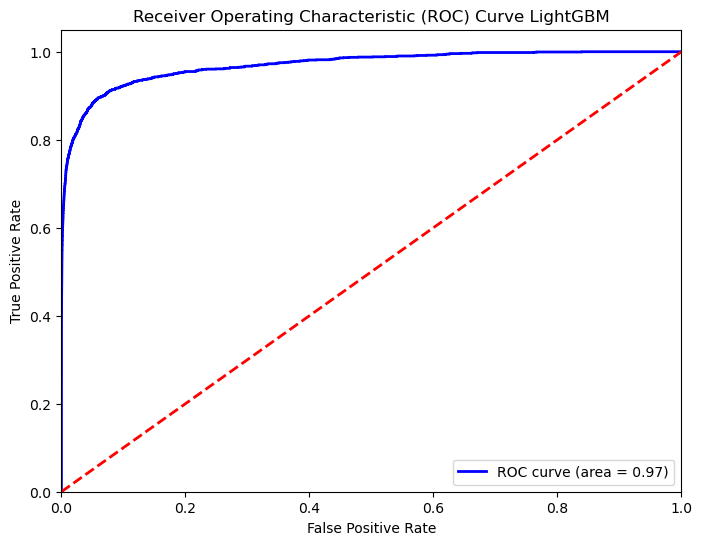

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba_lgbm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, Y_pred_proba_lgbm))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve LightGBM')
plt.legend(loc='lower right')
plt.show()

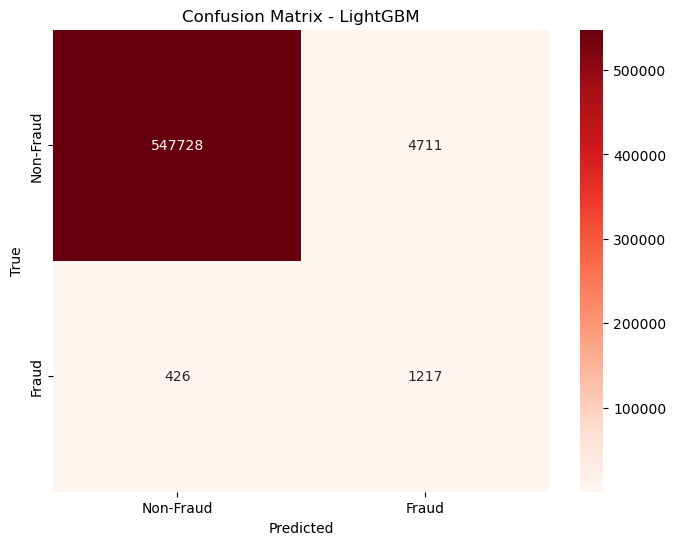

Confusion Matrix for LightGBM:
[[547728   4711]
 [   426   1217]]


In [86]:
# Plot confusion matrix for LightGBM
conf_matrix_lgbm = confusion_matrix(Y_test, Y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LightGBM')
plt.show()
# Print confusion matrix
print("Confusion Matrix for LightGBM:")
print(conf_matrix_lgbm)


Both LightGBM and XGBoost show strengths and weaknesses in different aspects of fraud detection. While LightGBM has fewer false positives, XGBoost exhibits better performance in correctly identifying fraudulent transactions, as evidenced by its higher number of true positives and lower number of false negatives. 

# Conclusion #

In the comparison of four machine learning models Logistic Regression, Random Forest, XGBoost, and LightGBM. 
LightGBM was top performer, being the highest F1 score and a great balance between precision and recall. Logistic Regression faced challenges with imbalanced datasets, resulting in lower recall and F1 scores. Although Random Forest showed improvement, XGBoost outperformed it with the highest recall and F1 scores. LightGBM surpassed all models with its exceptional F1 score. LightGBM's ability to minimize false positives was evident in its fewer occurrences compared to XGBoost in the confusion matrices. While XGBoost excelled in identifying fraudulent transactions, LightGBM achieved a better balance by reducing false positives, underscoring its effectiveness in fraud detection.









